# Load modules and data

In [1]:
# Import Python  print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

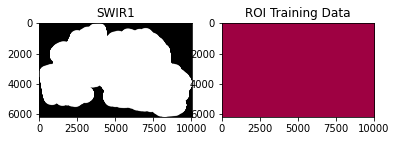

In [2]:
# Read in our image and ROI image
img_ds = gdal.Open('/home/dima/Desktop/WORK/GIS and ML algoritms/3_Classification_Sentinel_satelites/United_Sentinel_rasters/Mod_united_raster_20190824.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('/home/dima/Desktop/WORK/GIS and ML algoritms/3_Classification_Sentinel_satelites/Traning_rasters/mod_Traning_sample_20190824.tif', gdal.GA_ReadOnly)

# Copy the transformation to a variable
GT_input = img_ds.GetGeoTransform()

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

# Prepocessing of input data

In [3]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0]
y_interm = roi[roi > 0]
y = y_interm-1

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 2211 samples
The training data include 8 classes: [1 2 3 4 5 6 7 8]
Our X matrix is sized: (2211, 12)
Our y array is sized: (2211,)


In [4]:
# Convert data from array to pd dataframe

import pandas as pd

X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [5]:
# Columns in "X" data collections
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0156,0.0325,0.0172,0.3176,0.1344,0.0557,0.897252,-0.814339,0.701581,-14.600834,-8.462929,0.579620
1,0.0213,0.0382,0.0254,0.2190,0.1045,0.0516,0.792144,-0.702955,0.618625,-13.584172,-8.335326,0.613606
2,0.0374,0.0681,0.0614,0.2032,0.1730,0.1160,0.535903,-0.497973,0.273183,-16.191187,-10.743162,0.663519
3,0.0138,0.0356,0.0179,0.3118,0.1388,0.0575,0.891416,-0.795049,0.688600,-15.390807,-8.934840,0.580531
4,0.0128,0.0313,0.0167,0.2544,0.1400,0.0581,0.876798,-0.780889,0.628160,-13.377872,-7.742314,0.578740


In [6]:
# Columns in "y" data collections
y.head()

,0
0,5
1,5
2,1
3,5
4,5


# Create first XGBoost model for estimate varibiality of output stats

In [7]:
#  Importing the main library for building model and its analysis
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification

In [8]:
# K-Folds cross-validation for estimation "quality" of input data for building model
X_kfold = pd.DataFrame(X).to_numpy()
y_kfold = pd.DataFrame(y).to_numpy()

In [9]:
# Function for comparing datasets on homogeneity 
def display_scores(scores):
    print("    Scores: {0}\n    Mean: {1:.3f}\n    Std: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [10]:
# Output results of K-Folds cross-validation for XGBoost model
kfold = KFold(n_splits=5, shuffle=True)
scores = []
for train_index, test_index in kfold.split(X_kfold):   
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]

    xgb_model = xgb.XGBClassifier(objective="multi:softprob", use_label_encoder=False)
    xgb_model.fit(X_train, y_train, eval_metric=['mlogloss'])
    
    y_pred = xgb_model.predict(X_test)
      
    scores.append(accuracy_score(y_test, y_pred))
    
print('Accuracy classification score: \n')
display_scores(scores)
print('\n', 20*'-')

Accuracy classification score: 

    Scores: [0.8442437923250564, 0.8461538461538461, 0.8438914027149321, 0.8461538461538461, 0.8257918552036199]
    Mean: 0.841
    Std: 0.008

 --------------------


# Find optimal hyperparameters for XGBoost model

In [11]:
# Create function for present of hyperparameters and main scores
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            global hps
            hps =  results['params'][candidate]
            print("")

In [12]:
# Tuning XGBoost parameters
xgb_model = xgb.XGBClassifier(objective="multi:softprob", use_label_encoder=False)
params = {
    "colsample_bytree": uniform(0.05, 0.9),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.3), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(50, 200), # default 100
    "subsample": uniform(0.3, 0.7)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=5000, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y, eval_metric=['mlogloss'])

report_best_scores(search.cv_results_, 1) # showing the best model

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
Model with rank: 1
Mean validation score: 0.848 (std: 0.017)
Parameters: {'colsample_bytree': 0.46263769780760494, 'gamma': 0.4076530193693614, 'learning_rate': 0.05713257641708951, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.3601252948102243}



In [24]:
# All output data for XGBoost models after tuning parameters
print(search.cv_results_)

{'mean_fit_time': array([1.32879639, 0.34319205, 1.1304493 , ..., 1.57663903, 4.93688021,
       2.56354485]), 'std_fit_time': array([0.14003272, 0.01314248, 0.08990709, ..., 0.04228118, 0.36056261,
       0.07463661]), 'mean_score_time': array([0.00647697, 0.00490899, 0.00567818, ..., 0.01028733, 0.0217072 ,
       0.0102067 ]), 'std_score_time': array([9.07068615e-05, 8.01239955e-04, 6.07238894e-04, ...,
       3.81773642e-03, 1.12623399e-02, 3.88228237e-03]), 'param_colsample_bytree': masked_array(data=[0.5576792184076974, 0.22408863193308626,
                   0.47437605283240336, ..., 0.08812499801507453,
                   0.7361027634105941, 0.7003428867388145],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.3152793077758505, 0.17563540658384091,
                   0.2679962455545907, ..., 0.26223999310669127,
                   0.25880674220749905, 0.2435897349839134],
   

In [25]:
# Overwrite hyperparameters data for the next step/stage
p1 = hps['colsample_bytree']     # colsample_bytree
print('Colsample_bytree: ' + str(p1))

p2 = hps['gamma']                # gamma
print('Gamma: ' + str(p2))

p3 = hps['learning_rate']        # learning_rate
print('Learning_rate: ' + str(p3))

p4 = hps['max_depth']            # max_depth
print('Max_depth: ' + str(p4))

p5 = hps['n_estimators']         # n_estimators
print('N_estimators: ' + str(p5))

p6 = hps['subsample']            # subsample
print('Subsample: ' + str(p6))

Colsample_bytree: 0.46263769780760494
Gamma: 0.4076530193693614
Learning_rate: 0.05713257641708951
Max_depth: 6
N_estimators: 77
Subsample: 0.3601252948102243


# Creating a basic XGBoost model

In [78]:
# Create DMatrix (is an internal data structure) 
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [79]:
# Generate test and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [80]:
# Implementation of the scikit-learn API for XGBoost regression
xgb_model = xgb.XGBClassifier(objective="multi:softprob", colsample_bytree=p1, gamma=p2, learning_rate=p3, 
                          max_depth=p4, n_estimators=p5+100, subsample=p6, eval_metric=['mlogloss'], use_label_encoder=False)

In [81]:
# Show all parameters of XGBoost model
print(xgb_model)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.46263769780760494,
              enable_categorical=False, eval_metric=['mlogloss'],
              gamma=0.4076530193693614, gpu_id=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05713257641708951,
              max_delta_step=None, max_depth=6, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=177,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob',
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None,
              subsample=0.3601252948102243, tree_method=None,
              use_label_encoder=False, validate_parameters=None, ...)


In [82]:
# Fitting the model 
xgb_model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_train, y_train), (X_test, y_test)])
# learning dynamics
y_pred = xgb_model.predict(X_test, ntree_limit=xgb_model.best_ntree_limit)

[0]	validation_0-mlogloss:1.92277	validation_1-mlogloss:1.92938
[1]	validation_0-mlogloss:1.79328	validation_1-mlogloss:1.80557
[2]	validation_0-mlogloss:1.68048	validation_1-mlogloss:1.69930
[3]	validation_0-mlogloss:1.58261	validation_1-mlogloss:1.60588
[4]	validation_0-mlogloss:1.49392	validation_1-mlogloss:1.52306
[5]	validation_0-mlogloss:1.41582	validation_1-mlogloss:1.44965
[6]	validation_0-mlogloss:1.34418	validation_1-mlogloss:1.37984
[7]	validation_0-mlogloss:1.28004	validation_1-mlogloss:1.32040
[8]	validation_0-mlogloss:1.22119	validation_1-mlogloss:1.26504
[9]	validation_0-mlogloss:1.16756	validation_1-mlogloss:1.21544
[10]	validation_0-mlogloss:1.11773	validation_1-mlogloss:1.16941
[11]	validation_0-mlogloss:1.06888	validation_1-mlogloss:1.12378
[12]	validation_0-mlogloss:1.02578	validation_1-mlogloss:1.08457
[13]	validation_0-mlogloss:0.98432	validation_1-mlogloss:1.04474
[14]	validation_0-mlogloss:0.94619	validation_1-mlogloss:1.00945
[15]	validation_0-mlogloss:0.91171	

/home/dima/anaconda3/envs/geo_env/lib/python3.6/site-packages/xgboost/core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [83]:
# Iteration with the best result
optimal_n= xgb_model.best_ntree_limit-1
print("The best iteration: " + str(optimal_n))    

The best iteration: 140


In [84]:
# Preparing data for building a learning graph
results = xgb_model.evals_result()

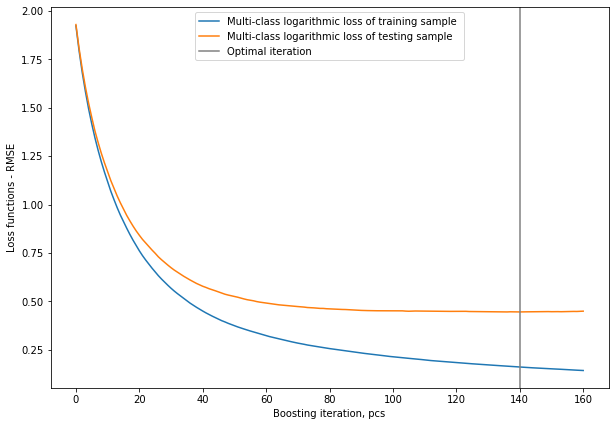

In [85]:
# Learning curves for the XGBoost model 
plt.figure(figsize=(10,7))
plt.plot(results['validation_0']['mlogloss'], label='Multi-class logarithmic loss of training sample ')
plt.plot(results['validation_1']['mlogloss'], label='Multi-class logarithmic loss of testing sample')
plt.axvline(optimal_n, color="gray", label="Optimal iteration")
plt.xlabel("Boosting iteration, pcs")
plt.ylabel("Loss functions - RMSE")
plt.legend()

# Estimation of a basic XGBoost model

In [86]:
# Comparison of training and testing prediction values for XGBoost model 

# Obtain prediction values for testing empirical data 
y_pred_train = xgb_model.predict(X_train, ntree_limit=xgb_model.best_ntree_limit)

# Prediction and Classification Report
from sklearn.metrics import classification_report

print('Model XGboost report for testing data:') 
print(classification_report(y_test, y_pred))
print(20*'-' + '\n' + 'Model XGboost report for training data:\n' + classification_report(y_train, y_pred_train))


Model XGboost report for testing data:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.73      0.89      0.80         9
           2       0.68      0.85      0.76        81
           3       0.79      0.64      0.70        58
           4       0.56      0.41      0.47        74
           5       0.94      0.98      0.96       401
           6       0.80      0.40      0.53        10
           7       0.50      0.33      0.40        12

    accuracy                           0.85       664
   macro avg       0.75      0.68      0.70       664
weighted avg       0.84      0.85      0.84       664

--------------------
Model XGboost report for training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.94      0.89      0.92        19
           2       0.92      0.96      0.94       165
           3       0.95      0.9

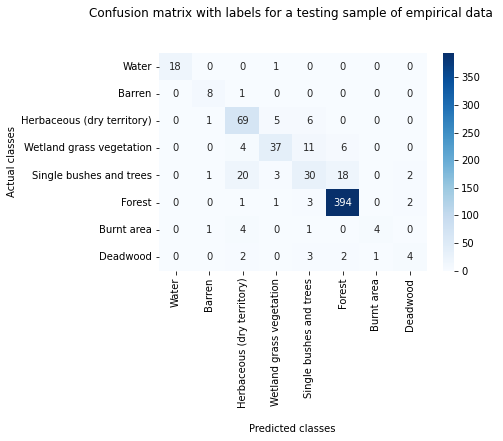

<Figure size 2160x2160 with 0 Axes>

In [87]:
import seaborn as sns 

# Create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

ax.set_title('Confusion matrix with labels for a testing sample of empirical data \n\n');
ax.set_xlabel('\nPredicted classes')
ax.set_ylabel('Actual classes');

# Name`s class list
ax.xaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])
ax.yaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])

## Display the visualization of the Confusion Matrix
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.figure(figsize =(30, 30))
plt.show()

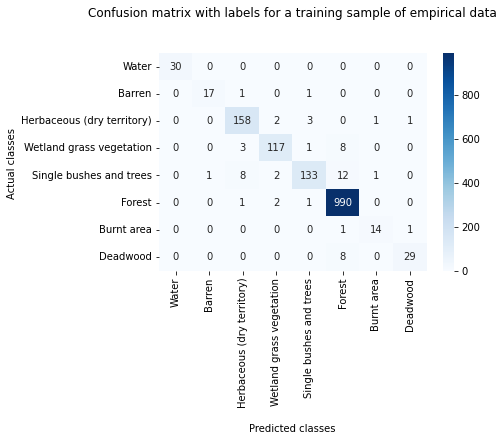

<Figure size 2160x2160 with 0 Axes>

In [88]:
# Create confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred_train)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

ax.set_title('Confusion matrix with labels for a training sample of empirical data\n\n');
ax.set_xlabel('\nPredicted classes')
ax.set_ylabel('Actual classes ');

# Name`s class list
ax.xaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])
ax.yaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])

## Display the visualization of the Confusion Matrix
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.figure(figsize =(30, 30))
plt.show()

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

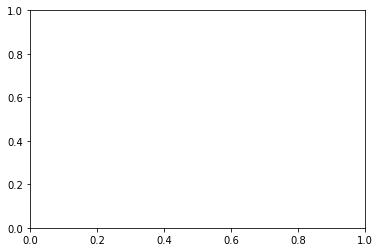

In [89]:
# Visualize the Decision tree (individual obs.)
xgb.plot_tree(xgb_model, num_trees=0) # "num_trees" is number of obs.
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

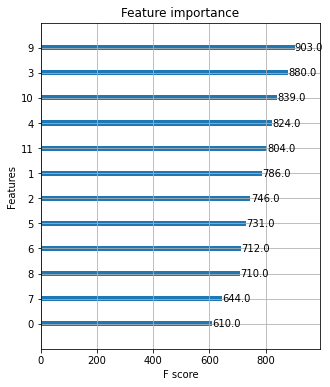

In [92]:
# Importance is calculated as: ”weight” is the number of times a feature appears in a trees
xgb.plot_importance(xgb_model, importance_type='weight')
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

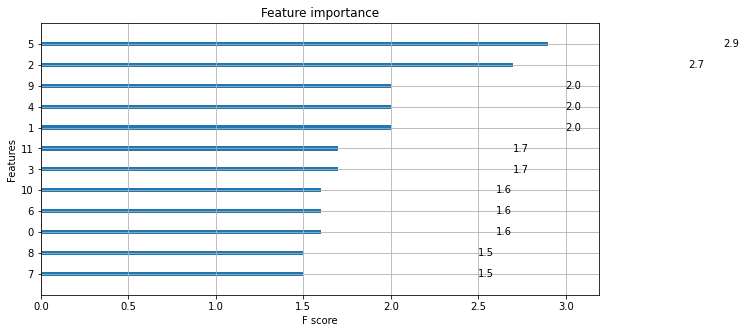

In [93]:
# Importance is calculated as: ”gain” is the average gain of splits which use the feature
# Get the booster from the xgbmodel
booster = xgb_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key], 1)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, importance_type='gain', show_values=True)
plt.rcParams['figure.figsize'] = [5, 6]

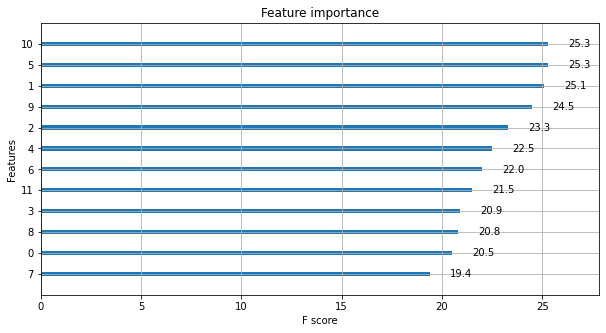

In [95]:
# Importance is calculated as: "cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split
# Get the booster from the xgbmodel
booster = xgb_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="cover")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key],1)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, importance_type='cover', show_values=True)
plt.rcParams['figure.figsize'] = [10, 5]

# SHAP method

In [96]:
# Load SHAP`s library
import shap

/home/dima/anaconda3/envs/geo_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [97]:
# Сreate an уxplainer object
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


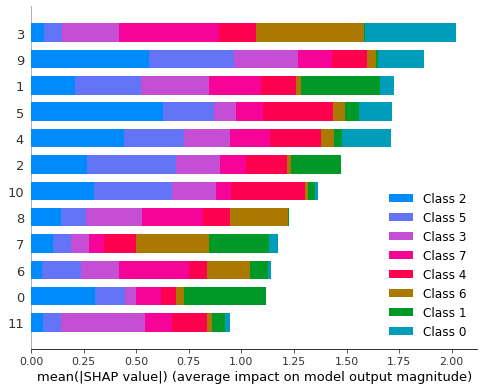

In [98]:
# Mean absolute value of the SHAP values for each feature 
shap.summary_plot(shap_values, X_train, plot_type="bar")

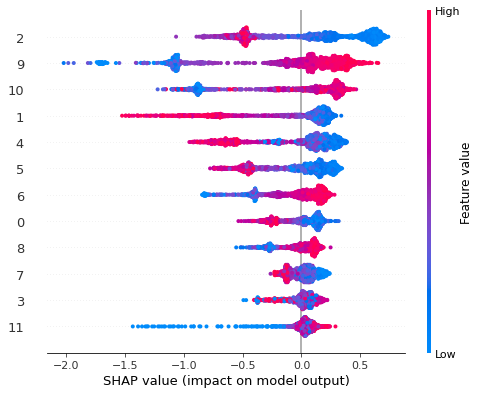

In [99]:
# Graph that summarises the effects of individual features (shap.values[feature])
shap.summary_plot(shap_values[5], X_train)

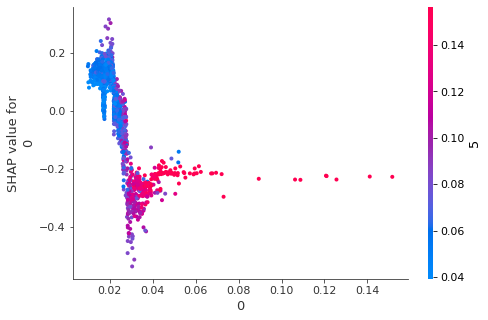

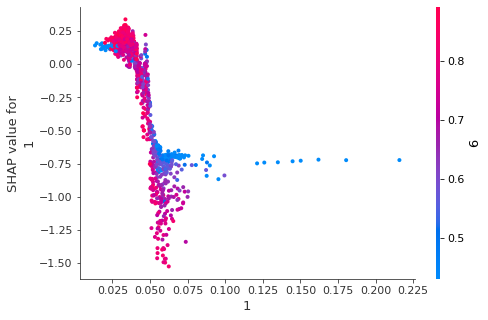

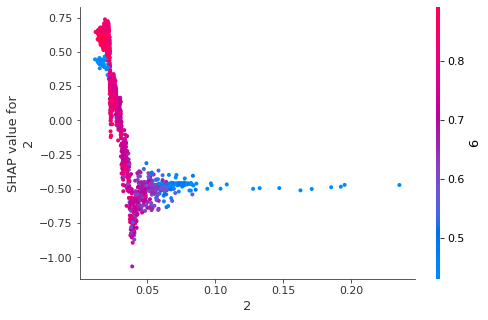

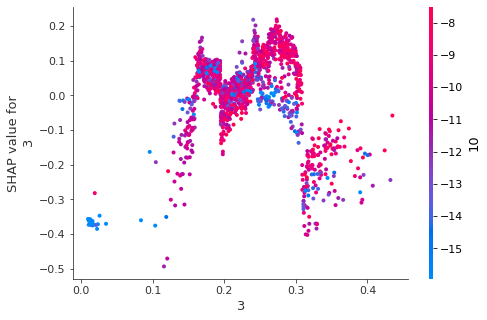

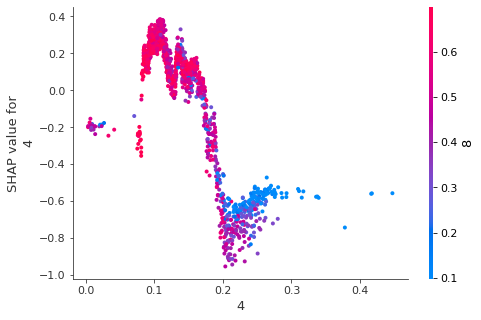

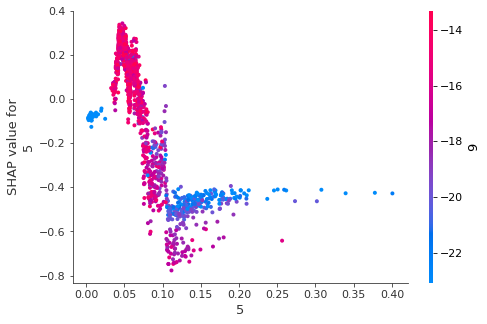

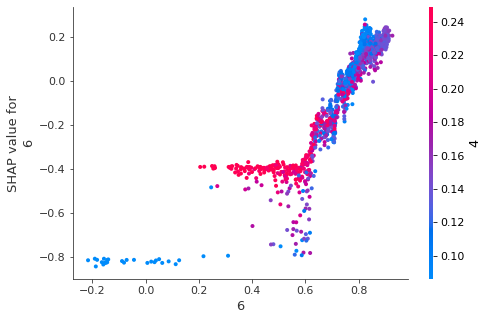

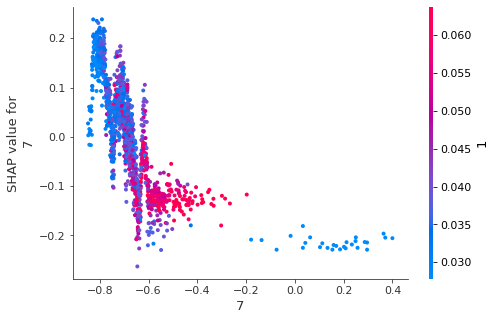

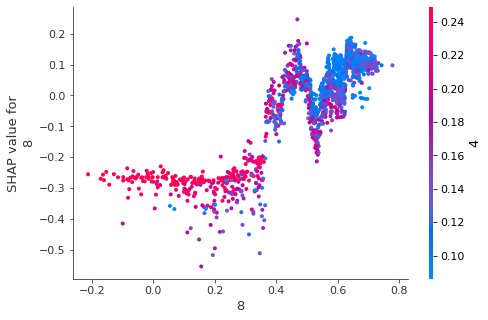

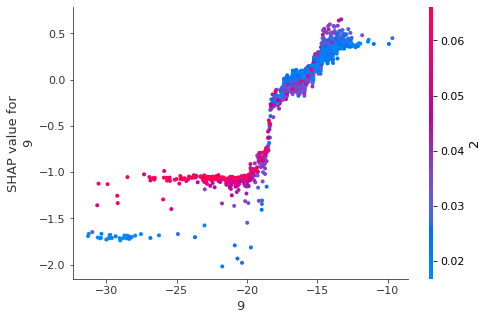

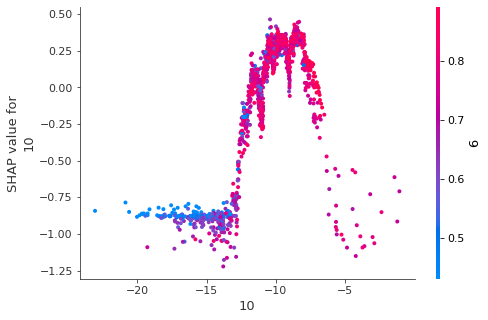

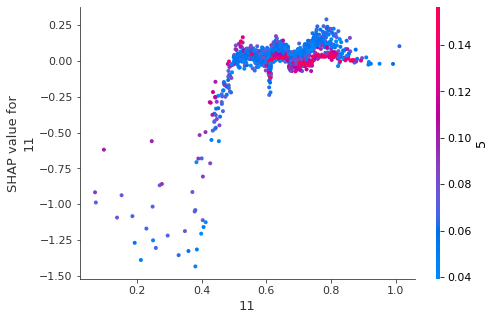

In [100]:
# Create a dependence scatter plot to show the effect of a single feature across the whole dataset
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[5], X_train, color=shap_values)

# Save XGBoost model

In [101]:
# Save to JSON
xgb_model.save_model("/home/dima/Desktop/WORK/GIS and ML algoritms/3_Classification_Sentinel_satelites/Classification_results/xgb_model_Sentinel_classific_2019.json")
# Save to text format
xgb_model.save_model("/home/dima/Desktop/WORK/GIS and ML algoritms/3_Classification_Sentinel_satelites/Classification_results/xgb_model_Sentinel_classific_2019.txt")

# Classification of all interest territory

In [102]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img.reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

Reshaped from (6160, 10008, 12) to (61649280, 12)


In [103]:
# Now predict for each pixel
class_prediction = xgb_model.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

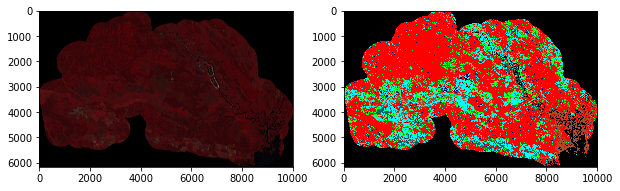

In [104]:
# Visualize

# First setup a 3-2-1 composite
def color_stretch(image, index, minmax=(-20, 1)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img321 = color_stretch(img, [3, 2, 1], (0, 1))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 255, 255)),  # Water
    (1, (0, 0, 0, 255)),  # Barren
    (2, (0, 100, 100, 255)),  # Herbaceous (dry teritory)
    (3, (0, 255, 255, 255)),  # Wetland grass vegetation
    (4, (160, 82, 45, 255)), # Single bushes and trees
    (5, (0, 255, 0, 255)),  # Forest
    (6, (255, 0, 0, 255)),  # Burnt area
    (7, (0, 0, 100, 255)),  # Deadwood    
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img321)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

# Save classification raster

In [105]:
import rasterio

In [106]:
output = np.float32(class_prediction)

In [108]:
# Save classification raster
from affine import Affine
af_transf = Affine.from_gdal(*GT_input)

with rasterio.open(
    '/home/dima/Desktop/WORK/GIS and ML algoritms/3_Classification_Sentinel_satelites/Classification_results/classif_map_2019.tif',
    'w',
    driver='GTiff',
    height=class_prediction.shape[0],
    width=class_prediction.shape[1],
    count=1,
    dtype=np.float32,
    transform=af_transf
) as dest_file:
    dest_file.write(class_prediction, 1)
dest_file.close()